### [Video Explanation Here!](https://youtu.be/Sf09t4b8E2I)


### Why are we talking about data safety in a Python class?

It's common for folks to learn Python in preparation for projects or careers in data engineering, data science, or machine learning. All of these roles require you to be able to interpret data and draw conclusions from it. 

Here's the danger: there are a lot of ways to generate numbers, and one number doesn't necessarily look any more suspicious than another number. This is why it's so easy for research organizations with different slants, for example, to draw two different conclusions from the same data.

But what we're going to talk about today is not _intentional_ slant. Instead, we're goig to talk about some honest but costly mistakes that often happen in bona fide scientific papers published in hard science journals. The researchers did not necessarily intentionally slant the paper—they just didn't have the statistical safeguards in place to come to a sound and accurate conclusion about the things they were researching.

I'm teaching you statistical safety in a Python class for the same reason you'd learn knife safety in a knife skills class. You can impact lots of lives with the work you're doing, and if it's data manipulation or interpretation work, I want to make sure you have some idea what's going on.

## We use data to build models.

In the literal sense, we use them to build machine learning models, but we also use them to shape our mental models—our understandings of cause and effect. Models are almost never 100% accurate—rather, they're a simplified representation of a phenomenon that gives us a way to wrap our heads around it.

When you analyze a set of numbers, you have to keep in mind that that set doensn't represent _all_ the numbers in the world. Take, for example, your height. How tall are you? Could you use that information to extrapolate that everybody in the world is the same height as you?

Of course not! That's just one data point. Now imagine we took the heights of everyone in this class. Would that give us a _better_ idea of how tall people are, in the world, in general, than just _your_ height? It would, but it still wouldn't be the full picture. We probably don't have the tallest or the shortest person in the world in this class. The average height in this class might not really match the average height of _everyone_ in the world, especially because huge parts of the world's population are completely not represented in this class.

Most data analysis attempts to draw conclusions about something based on an incomplete subset of the total data about that thing. Statistical methods give us a way to quantify how wrong we might be about our extrapolations.

## Enter the distribution and the standard deviation.

[Here's a review](https://www.mathsisfun.com/data/standard-normal-distribution.html) of those concepts from math is fun.

## Confidence Intervals

A confidence interval helps us answer the question: "Based on how much data we have sampled and how much the values in that sample differ from each other, how far away from our sample mean could the _true_ mean be?"

> A confidence interval is a range around a measurement that conveys how precise the measurement is. For most chronic disease and injury programs, the measurement in question is a proportion or a rate (the percent of New Yorkers who exercise regularly or the lung cancer incidence rate). Confidence intervals are often seen on the news when the results of polls are released. This is an example from the Associate Press in October 1996:

> "The latest ABC News-Washington Post poll showed 56 percent favored Clinton while 39 percent would vote for Dole. The ABC News-Washington Post telephone poll of 1,014 adults was conducted March 8-10 and had a margin of error of plus or minus 3.5 percentage points. (Emphasis added)."

> Although it is not stated, the margin of error presented here was probably the 95 percent confidence interval. In the simplest terms, this means that there is a 95 percent chance that between 35.5 percent and 42.5 percent of voters would vote for Bob Dole (39 percent plus or minus 3.5 percent). Conversely, there is a 5 percent chance that fewer than 35.5 percent of voters or more than 42.5 percent of voters would vote for Bob Dole.

> The precise statistical definition of the 95 percent confidence interval is that if the telephone poll were conducted 100 times, 95 times the percent of respondents favoring Bob Dole would be within the calculated confidence intervals and five times the percent favoring Dole would be either higher or lower than the range of the confidence intervals.

> Instead of 95 percent confidence intervals, you can also have confidence intervals based on different levels of significance, such as 90 percent or 99 percent.  - [New York State Dept of Health](https://www.health.ny.gov/diseases/chronic/confint.htm)

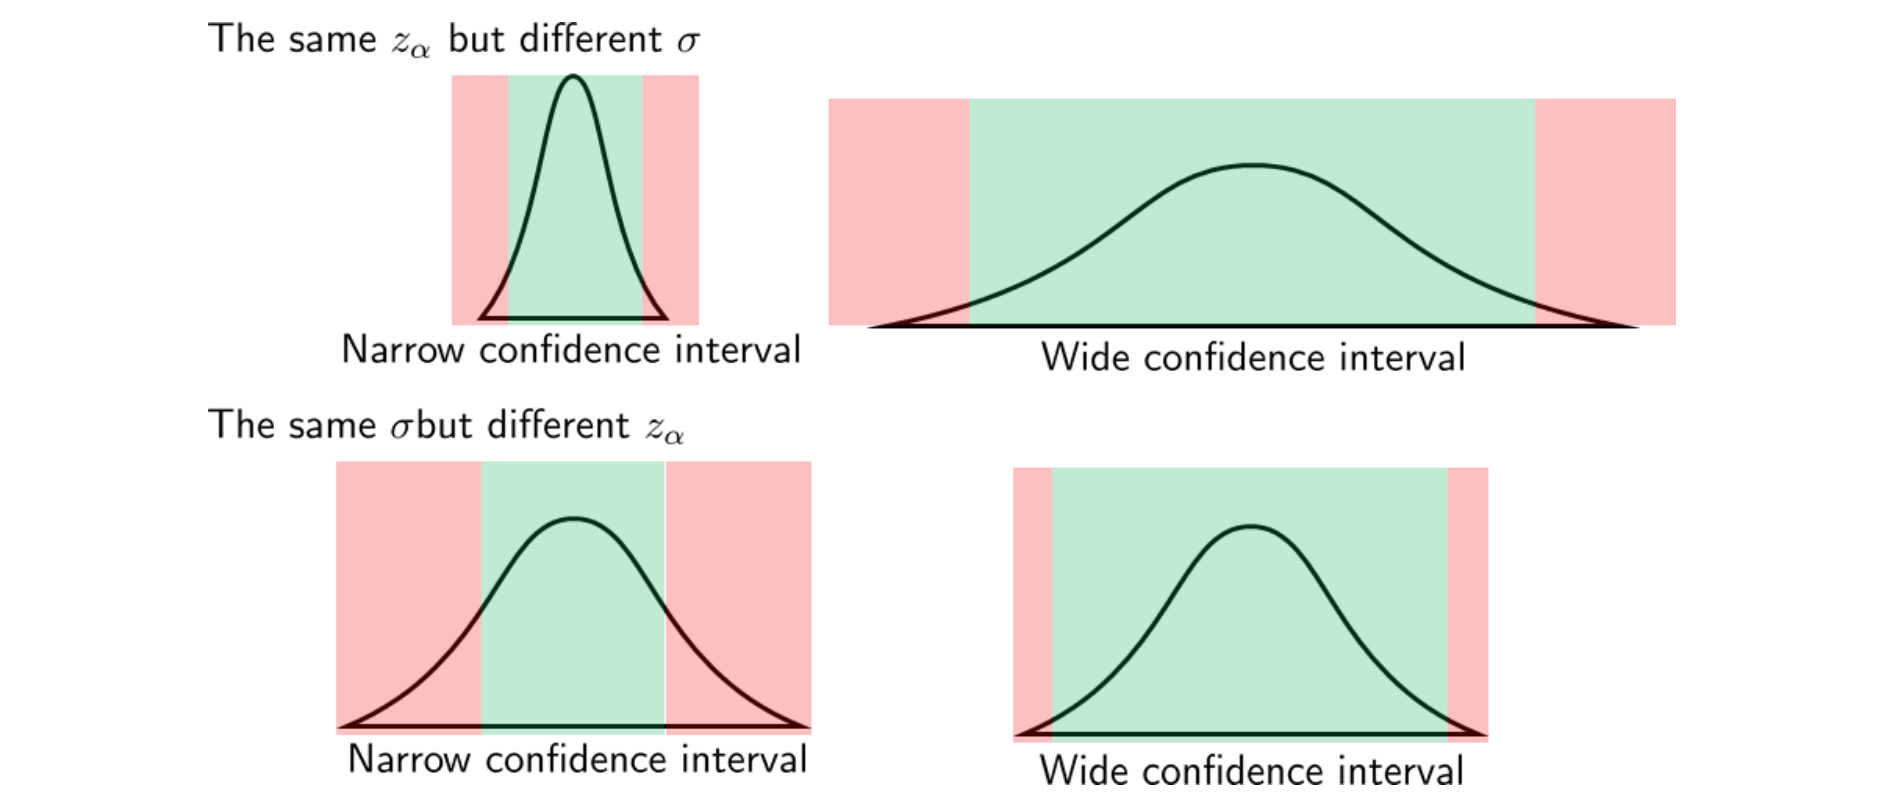 [Stanley Chan, Purdue University, 2017](https://engineering.purdue.edu/~milind/datascience/2018spring/notes/lecture-7.pdf)

Typically we use the normal distribution for calculating confidence intervals when we have more than 120 samples. However, for really small numbers of samples (under 120), we can use the wider, flatter [t-distribution](https://www.statisticshowto.com/probability-and-statistics/t-distribution/), which _looks like_ the normal distribution at and above about 120 samples.

**This code calculates confidence intervals based on the mean, the size, and the standard deviation of several sets of data. It has a default condidence interval of 95%, but you can change it. It returns the upper and lower bounds of the confidence intervals around the means you passed in.**

Precisely, that means "Given this mean, standard deviation, and number of data points, there is a `confidence` probability that the _true_ mean for all the data that this dataset represents is between this lower number and this higher number."

In [ ]:
import sys
!{sys.executable} -m pip install scipy 

import math
from scipy.stats import t
import numpy as np

def confidence_interval_for_collection(sample_size=[], standard_deviation=[], mean=[], confidence=0.95):
    degrees_freedom = [count - 1 for count in sample_size]
    outlier_tails = (1.0 - confidence) / 2.0
    confidence_collection = [outlier_tails for _ in sample_size]
    t_distribution_number = [-1 * t.ppf(tails, df) for tails, df in zip(confidence_collection, degrees_freedom)]

    step_1 = [std/math.sqrt(count) for std, count in zip(standard_deviation, sample_size)]
    step_2 = [step * t for step, t in zip(step_1, t_distribution_number)]

    low_end = [mean_num - step_num for mean_num, step_num in zip(mean, step_2)]
    high_end = [mean_num + step_num for mean_num, step_num in zip(mean, step_2)]

    return low_end, high_end

**Programming Note**: This method is called a _collection method_ because it takes in _collections_ of values and does an operation on each one. It's useful, for example, for calculating confidence intervals for every mean in a collection of means stored in a DataFrame. You can _also_ use it on just one set of summary data, but you have to pass in the sample size, standard deviation, and mean of that dataset _inside of brackets_ to make a one-item colleciton, like this:

`confidence_interval_for_collection(sample_size=[217], standard_deviation=[0.05], mean=[0.62])`

Let's see it in action by calculating confidence intervals around the number of days that various Chicago municipal maintenance operations took:

In [ ]:
import pandas as pd
aggregation = pd.read_csv('metrics.csv') \
        .assign(year=lambda row: row["Period Start"].apply(lambda x: x[-4:])) \
        .assign(activity_year=lambda row: row["Activity"] + " (" + row["year"] + ")") \
        .assign(average_days_to_complete_activity=lambda row: row["Average Days to Complete Activity"].apply(lambda x: float(x))) \
        .groupby('activity_year') \
        .agg({
             'Target Response Days': 'max', 
             'average_days_to_complete_activity': ['mean','std'],
             'Activity' : 'count'
            })\
        .reset_index()

aggregation.columns = [' '.join(col).strip() for col in aggregation.columns.values]
aggregation["conf_interval_bottom"], aggregation["conf_interval_top"] = confidence_interval_for_collection(sample_size=aggregation["Activity count"], standard_deviation=aggregation["average_days_to_complete_activity std"], mean=aggregation["average_days_to_complete_activity mean"])

aggregation["average_slippage"] = aggregation["average_days_to_complete_activity mean"] - aggregation["Target Response Days max"]
aggregation["slippage_corrected"] = aggregation["conf_interval_top"] - aggregation["Target Response Days max"]

aggregation

### T-Tests

A T-test helps us answer the question: Is the distance between two means statistically significant? 

It's possible they are, even if their confidence intervals overlap.

**This code performs a T-test for two datasets given their sizes, standard deviations, and means. It has a default confidence of 95%, but you can change it. It returns a tuple of whether to accept the null hypothesis, and then the t-value.**

"Accept the null hypothesis" means "The difference between these two means is not statistically significan" or, more precisely, "there is a `1 - confidence` chance that the difference between these two means represents an _actual_ difference between these two datasets."

In [ ]:
def t_test_for(num_samples_1, standard_deviation_1, mean_1, num_samples_2, standard_deviation_2, mean_2, confidence=0.95):
    alpha = 1 - confidence
    total_degrees_freedom = num_samples_1 + num_samples_2 - 2

    t_distribution_number = -1 * t.ppf(alpha, total_degrees_freedom)

    degrees_freedom_1 = num_samples_1 - 1
    degrees_freedom_2 = num_samples_2 - 1
    sum_of_squares_1 = (standard_deviation_1 ** 2) * degrees_freedom_1
    sum_of_squares_2 = (standard_deviation_2 ** 2) * degrees_freedom_2

    combined_variance = (sum_of_squares_1 + sum_of_squares_2) / (degrees_freedom_1 + degrees_freedom_2)
    first_dividend_addend = combined_variance/float(num_samples_1)
    second_dividend_addend = combined_variance/float(num_samples_2)

    denominator = math.sqrt(first_dividend_addend + second_dividend_addend)
    numerator = mean_1 - mean_2
    t_value = float(numerator)/float(denominator)

    accept_null_hypothesis = abs(t_value) < abs(t_distribution_number) #results are not significant

    return accept_null_hypothesis, t_value

In [ ]:
t_test_for(20, 0.05, 0.62, 10, 0.05, 0.63)

## A lot of the time, businesspeople are going to make decisions based on averages and nothing else.

For business decisions, this is often fine, and it's not worth the effort to be really statistically rigorous. However, there are situations where you _need_ to be using the confidence interval, such as:

- Weight tolerances for the materials being used to build a bridge ([Quebec Bridge Collapse, 1907](https://ascelibrary.org/doi/abs/10.1061/%28ASCE%290887-3828%282006%2920%3A1%2884%29#:~:text=The%20panel's%20report%20found%20that,immediately%20followed%20by%20Chord%20A9R.))
- Temperature tolerances for the O-rings on the solid rocket boosters for the space shuttle ([Challenger Disaster, 1986](https://www.space.com/31732-space-shuttle-challenger-disaster-explained-infographic.html))
- Amount of a toxic substance in a municipal water source ([Flint, Michigan, 2014-present](https://www.npr.org/sections/thetwo-way/2016/04/20/465545378/lead-laced-water-in-flint-a-step-by-step-look-at-the-makings-of-a-crisis))
- Effectiveness of a vaccine ([COVID, 2019-present](https://www.nejm.org/doi/full/10.1056/NEJMoa2034577))

Any situation where people's health, safety, and quality of life depend on how you act on this data.

So that's the math part. Now let's talk about some plain old study design problems that you'll want to watch out for if someone asks you to analyze a bunch of data.

## Extrapolating based on a non-representative subset

A **confounding variable** is a factor that affects your data that you don't account for in your analysis that affects your results. There's an effect in statistics called **Simpson's Paradox** that sounds very fancy and ends up being basically this. The effect happens when subgroups of data show one trend, but the entirety of the data shows the opposite trend. Let's talk about an example:

A 1973 study of gender bias at [UC Berkeley](https://www.refsmmat.com/posts/2016-05-08-simpsons-paradox-berkeley.html) revealed that, on the whole, women were admitted to the school at a lower rate than men. It turned out, when the data was broken down by department, that women were admitted at a _higher_ rate than men. What happened: women were applying to the programs that were harder to get into. **It's really important to track down your confounding variables as much as possible.**

Here's a common medical example that has been an issue for ages: BMI. Body Mass Index scores are used to determine how "healthy" people are based on their weight-to-height ratio. The problem is that the [BMI scale](https://www.newsweek.com/2017/05/19/obesity-childhood-obesity-body-mass-index-bmi-weight-weight-gain-health-595625.html) was developed based on a sample of white people and overrepresents white men in particular. It doesn't extrapolate well to other people's bodies (and it _especially_ pathologizes black women's bodies). As a result, doctors deny care to people who need it because they "need to lose weight first" according to a metric that was not built for their bodies. 

**One way to track down confounding variables is to make sure that the _distribution_ of your sample set on each variable you have on record _matches_ the distribution of the population you're trying to extrapolate to.** Doctors right now are trying to do this with COVID vaccines: they want the trials to include people of all ethnicities so they don't make a safety claim based only on white people and then start injecting a substance into people's arms with no info about how it might affect them. Getting study participants has been difficult, though, because this country's history with performing reckless medical experiments on black people in particular (for example, the [Tuskeegee Study](https://www.mcgill.ca/oss/article/history/40-years-human-experimentation-america-tuskegee-study)) gives BIPOC really good reasons to be wary of the medical establishment.

## Multiple Comparisons

You may have 95% certainty that any one comparison isn’t statistically significant by fluke, but when you run a bunch of comparisons, eventually one of them will be a fluke. In fact, when you run 100 separate comparisons, your likelihood that none of the significant outcomes are flukes drops to a measly 1%.

There's a comic about [jelly beans](https://stats.stackexchange.com/questions/88065/explain-the-xkcd-jelly-bean-comic-what-makes-it-funny) that illustrates this.

One solution is the **Bonferroni correction**: divide your intended p value by the number of comparisons you're running. This method gets criticism for being to harsh and missing important findings, so sometimes folks temper it by _lowering_ the P value, but not all the way to the Bonferroni correction prescription.

## Continuity Errors

This type of data representation error happens when someone misrepresents continuous data that does not fall into discrete categories (like body mass index) and either misrepresents it as discrete categories or interprets it in some way that isn’t true to the data. 

For example, with body mass index, we frequently see two categories: ‘normal weight’ and ‘overweight.’ So first of all, body mass index as a metric in the first place has been demonstrated to be a poor measure of health and fitness. So, we already have some issues. But let’s stick to continuity errors specifically. 

Frequently body mass index data gets categorized as ‘normal weight’ (24.9 or lower) or ‘overweight’ (above 24.9). Where is underweight? Also, what is the difference between a 24.8 and a 25.1? When these middle values get averaged together with extremes on either end, it looks like this 0.2 difference in the middle is a night and day difference. It’s not. We’re just representing a wide range with a tiny number of categories. 

It’s worth examining whether and why we need to categorize continuous variables before we do it. There are good reasons (get evenly sized buckets of points to compare means, draw meaningful visualizations, et cetera). But it’s not a default thing to do.